Starting from a 
* pre-trained model with a 
* pre-trained tokenizer

we perform finetuning on a negation task

Tweakable:
* test-time augmentation
* flattening B-, I-
* block-size
* batch-size
* gradient

Experiments:
* (negation paper) 32 block size, 32 batch size, with/without centered validation
  * MedRoBERTa.nl
  * RobBERT v2
* 32 block size, 32 batch size, with centered validation, 1-12 layers 
  * MedRoBERTa.nl
  * RobBERT v2

In [1]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import dotenv
import numpy as np
import random
import json
from tqdm import tqdm

try:
    from torch.nn import CrossEntropyLoss
except ImportError:
    # load .env
    dotenv.load_dotenv(dotenv.find_dotenv())
    os.environ['LD_LIBRARY_PATH'] = os.getenv('LD_LIBRARY_PATH')
    from torch.nn import CrossEntropyLoss
    

from torch.utils.data import Dataset, DataLoader
from torch import device, cuda, version

#import apex
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from collections import namedtuple
from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForTokenClassification
from transformers import AutoModelForSequenceClassification

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import dcc_splitter as splitter
from utils import ner_training as trainer
#import dcc_splitter as splitter

use_gpu = True

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
if cuda.is_available():
    print('CUDA, GPU, is working')
    os.system("espeak 'CUDA, GPU, is working!'")
else:
    print('CUDA, GPU, is not working')
    os.system("espeak 'CUDA, GPU, is NOT working!'")
    
device = device("cuda:0") if (cuda.is_available()) & (use_gpu==True) else device("cpu")

CUDA, GPU, is working


In [4]:
#base_folder = "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels"
base_folder = "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models"

dcc_dir = None
output_dir = os.path.join(base_folder, "finetuned")
skip_file = '../data/EMCDutchClinicalCorpus/DCC_files_to_exclude.json'
n_splits = 10
random_state = 42
reduce_tags = False
centered_testing = True
train_on_all = True
zero_shot = False # do not train the attention layers, only the final linear layer
#num_trainable_layers = None # None: all, overrides zero_shot
mod_name = "base/medroberta" # "finetuned/negation_512"
ASL = True
ASL_level = 1
ASL_str = f"ASL_{ASL_level}" if ASL else "noASL"

args = namedtuple
args.task = "Temporality" # experiencer, temporality, negation
args.model_path = os.path.join(base_folder, mod_name)
args.model_type = "roberta" # bertje 
args.num_epochs = 5 # 10 for zero-shot
args.eval_steps = 500 
args.lr =  2e-5 # 5e-5 for non-zeroshot 64 bs, 5e-3 for zero-shot 128 bs, 1e-4 for nonzeroshot 32 bs
args.batch_size= 32 #4
args.gradient_accumulation_steps = 1 #16
args.block_size = 64 # 512 
args.save_model=True
args.bio=True
args.do_eval=True
args.do_write=True
args.bootstrap=False
args.do_print_class_report=False
args.amp=True

mod_name = mod_name.replace("/","_").replace("-","_")+"_"+"_".join([str(args.num_epochs), 
                                                   str(args.batch_size*args.gradient_accumulation_steps), 
                                                   str(args.block_size),
                                                   "zeroShot" if zero_shot else "",
                                                   "centeredVal" if centered_testing else "",
                                                   args.task,
                                                   ASL_str])
mod_name = mod_name.strip("_")
output_folder = "fine_tuned_token_"+args.task+"_"+mod_name

args.output_dir = os.path.join(output_dir, output_folder)

# check if the output folder exists
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

random.seed(77)

In [5]:
# args.block_size determines how many text snippets are  used for training, see ner_training.py lines 118--141
# obviously this is a code-design flaw that should be mended.
# the dataset loader should  include the id_begin_end in the output

In [6]:
# load NER DCC set
dcc = pd.read_csv("../data/DCC_df_ASL1_Historical.csv", 
                  sep="\t", 
                  skip_blank_lines=True, 
                  engine="python", 
                  encoding="latin1",
                  on_bad_lines='warn', 
                  keep_default_na=False)

In [7]:
dcc.Temporality.value_counts()

Temporality
O               305866
Recent           18860
Historical        5063
Hypothetical       642
Name: count, dtype: int64

In [8]:
dcc.Negation.value_counts()

Negation
O             310592
NotNegated     16781
Negated         3058
Name: count, dtype: int64

In [9]:
dcc.Experiencer.value_counts()

Experiencer
O          309181
Patient     19825
Other        1425
Name: count, dtype: int64

In [10]:
dcc.BIO.value_counts()

BIO
O    304446
B     15274
I     10711
Name: count, dtype: int64

In [11]:
dcc.loc[dcc.BIO!='O'][['Id', 'Begin', 'End']].apply(lambda x: "_".join(str(x)), axis=1).nunique()

25985

In [12]:
Texts = dcc.groupby('Id').Word.apply(lambda x: " ".join(x))

In [13]:
if reduce_tags:
    tag_ids = {'Negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':0,'I-NotNegated':1},
              'Temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':0,
                             'I-Historical':1,'I-Hypothetical':2},
              'Experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':0,'I-Other':1}}
else:
    tag_ids = {'Negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':2,'I-NotNegated':3},
              'Temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':3,
                             'I-Historical':4,'I-Hypothetical':5},
              'Experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':2,'I-Other':3}}

tag2id = tag_ids[args.task]
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

In [14]:
dcc['num_tokens'] = dcc.Word.apply(lambda x: len(tokenizer.tokenize(x)))
dcc['cumsum_tokens'] = dcc.groupby('Id').num_tokens.cumsum()
dcc['letter_type'] = dcc.Id.str.slice(0,2)
tokens_df = dcc.groupby(['Id', 'letter_type']).cumsum_tokens.agg(num_tokens=max).reset_index()

Mean 
DL tokens: 67.19376391982182
SP tokens :86.52734163508391
RD tokens :34.00299850074963
GP tokens :33.01314116150911


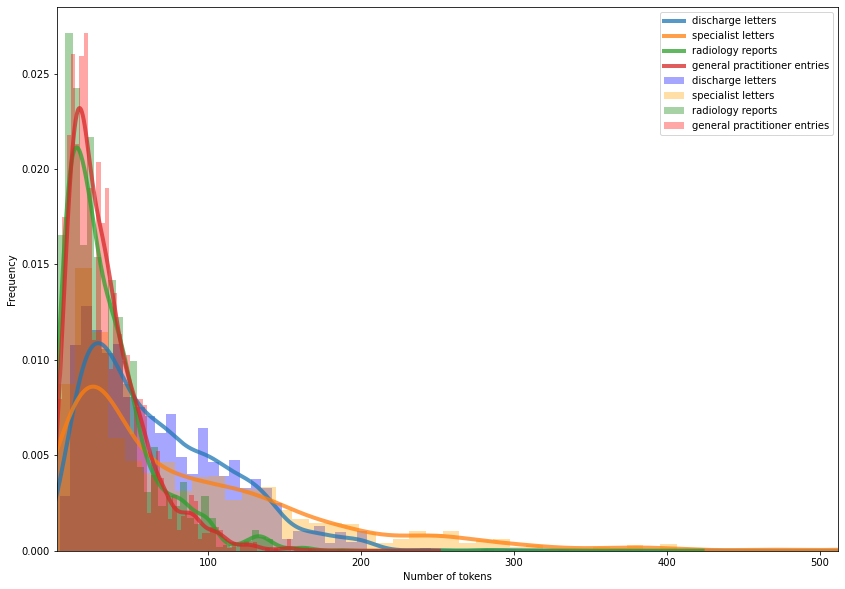

In [15]:
plt.figure(figsize=(14,10))
tokens_df[(tokens_df.letter_type=='DL')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='discharge letters')
tokens_df[(tokens_df.letter_type=='SP')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='specialist letters')
tokens_df[(tokens_df.letter_type=='RD')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='radiology reports')
tokens_df[(tokens_df.letter_type=='GP')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='general practitioner entries')

tokens_df[(tokens_df.letter_type=='DL')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='blue',
                                              label='discharge letters')
tokens_df[(tokens_df.letter_type=='SP')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='orange',
                                              label='specialist letters')
tokens_df[(tokens_df.letter_type=='RD')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='green',
                                              label='radiology reports')
tokens_df[(tokens_df.letter_type=='GP')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='red',
                                              label='general practitioner entries')


plt.legend()
#plt.semilogx()
plt.xlabel("Number of tokens")
plt.xlim(1,512)

print(f"Mean \nDL tokens: {tokens_df[(tokens_df.letter_type=='DL')].num_tokens.mean()}\n\
SP tokens :{tokens_df[(tokens_df.letter_type=='SP')].num_tokens.mean()}\n\
RD tokens :{tokens_df[(tokens_df.letter_type=='RD')].num_tokens.mean()}\n\
GP tokens :{tokens_df[(tokens_df.letter_type=='GP')].num_tokens.mean()}")

In [16]:
# find I that is not preceeded by a B..
def prior_equal_to(x, equal_to='O'):
    if isinstance(x, pd.Series):
        _x = np.array(x.values)
        xout= np.zeros_like(_x)
        for i in range(1, len(_x)):
            xout[i] = (_x[i-1] == equal_to)
        return xout
    else:
        x = np.nan
        return x

In [17]:
dcc['O_as_prior'] = dcc.groupby('Id').BIO.transform(prior_equal_to, equal_to='O')
dcc['I_as_prior'] = dcc.groupby('Id').BIO.transform(prior_equal_to,  equal_to='I')
dcc['SpecialChar_as_prior'] = dcc.groupby('Id').Word.transform(prior_equal_to,
                                                           **{'equal_to':['.', ',', ':', ';', 
                                                                          '!', '?','-','+']})

In [18]:
dcc.loc[(dcc.BIO=='I') & (dcc.O_as_prior==True), 'BIO'] = 'B'
dcc.loc[(dcc.BIO=='I') & (dcc.SpecialChar_as_prior==True), 'BIO'] = 'B'

In [19]:
# for centering, just change the dcc..
# improvement: add boolean to indicate whether entity is in center, process in training routine :)
sub_dfs = []
for _id in tqdm(dcc.Id.unique()):
    cst_list = dcc[(dcc.Id==_id) & (dcc.BIO=='B')].cumsum_tokens.to_list()
    for l, cst in enumerate(cst_list):
        sub_df = dcc[(dcc.Id==_id) & 
                (dcc.cumsum_tokens<cst+int(0.5*args.block_size)) &
                (dcc.cumsum_tokens>cst-int(0.5*args.block_size))].reset_index(drop=True)
        sub_df['center']=False
        sub_df.loc[sub_df.cumsum_tokens==cst, 'center'] = True
        sub_df.loc[:, 'sub_Id'] = l
        sub_dfs.append(sub_df)
_dcc = pd.concat(sub_dfs, axis=0).reset_index(drop=True)
_dcc['sub_Id'] = _dcc['sub_Id'].astype(str)
_dcc['Id'] = _dcc['Id'] + "_" + _dcc['sub_Id']
dcc = _dcc

100%|██████████| 8003/8003 [09:49<00:00, 13.58it/s]


## Over all document sources

improvement: 
* only output best model based on validation scores
* save results after each epoch --> should be included in train_model
* allow freezing specific layers: https://discuss.huggingface.co/t/how-to-freeze-some-layers-of-bertmodel/917

In [20]:
dcc.loc[:,'Begin'] = dcc['Begin'].astype(str)
dcc.loc[:, 'End'] = dcc['End'].astype(str)
dcc=dcc[['Id', 'Word', 'BIO', 'Negation', 'Experiencer', 
         'Temporality', 'Begin', 'End', 'center']]

In [21]:
# dcc-splitter for folds
unique_docs = dcc.Id.unique().tolist()
docs_ids = ["_".join(d.split("_")[:-1])for d in unique_docs]

# TODO: a lot of documents will not have any label for a specific task, these should be removed from the dataset at this point
labels = dcc.groupby('Id', as_index=True, sort=False)[args.task].apply(lambda x: x[x!='O'].mode().get(0) if not x[x!='O'].mode().empty 
                                            else pd.Series([np.nan])).reset_index()
labels = labels.loc[labels.Id==unique_docs]
labels['Id'] = labels['Id'].str.split("_").apply(lambda x: x[0])
labels = labels.set_index('Id')
labels = labels[labels.Temporality.apply(lambda x: type(x)==str)]
keep_index=labels.index

docs_ids = [d for d in docs_ids if d in keep_index]
group_ids = [d[:6] for d in docs_ids]

dcc_splitter = splitter.DCCSplitter(None,    # dcc_dir                                 
                                    None,    # output_dir
                                    skip_file, 
                                    n_splits, 
                                    random_state, 
                                    labels=labels,
                                    doc_ids=docs_ids,
                                    group_ids = group_ids,
                                    write_to_file=False, 
                                    stratified=True)
splits = dcc_splitter.split()

Checking 10 splits for overlap of document IDs
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


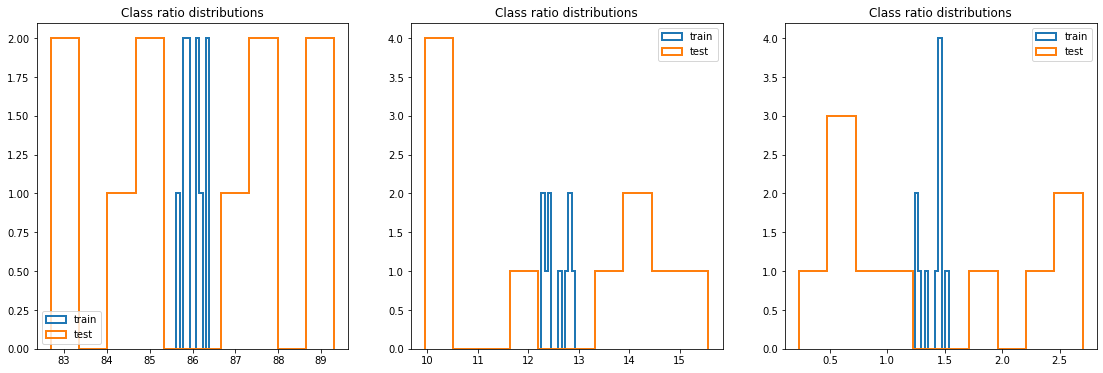

In [22]:
# check if there is no leakage
overlap_counts = []
label_ratios = []
print(f'Checking {len(splits)} splits for overlap of document IDs')
for _split in splits:
    test =  [_id[:7] for _id in _split['test']]
    train = [_id[:7] for _id in _split['train']]
    
    test_label_ratios = list(labels.loc[_split['test']][args.task].value_counts()/labels.loc[_split['test']][args.task].value_counts().sum()*100)
    train_label_ratios = list(labels.loc[_split['train']][args.task].value_counts()/labels.loc[_split['train']][args.task].value_counts().sum()*100)
    
    overlap_counts.append(len(set(test).intersection(set(train))))
    label_ratios.append((test_label_ratios, train_label_ratios))
print(overlap_counts)

arr_train_label_ratios = np.array([np.array(x[1]) for x in label_ratios])
arr_test_label_ratios = np.array([np.array(x[0]) for x in label_ratios])

n_classes =arr_train_label_ratios.shape[1]
fig, ax = plt.subplots(1,n_classes, figsize=(19,6))
for i in range(n_classes):
    ax[i].hist(arr_train_label_ratios[:,i], histtype='step', lw=2, label='train')
    ax[i].hist(arr_test_label_ratios[:,i], histtype='step', lw=2, label='test')
    ax[i].legend()
    ax[i].set_title('Class ratio distributions')

In [23]:
args.model_path

'//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta'

In [25]:
# cycle through folds
scores = []
predlist = []
test_lists = []
loss_history = {}
for idx, fold in tqdm(enumerate(splits)):
    # re-init model for each fold, otherwise it keeps on training the same throughout all folds..
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, 
                                                        num_labels = len(tag2id),
                                                        ignore_mismatched_sizes=True)
    
    if zero_shot:
        for name, param in token_model.named_parameters():
            if 'classifier' not in name: # classifier layer
                param.requires_grad = False

    train_list, test_list = fold['train'], list(set(fold['test']))
    
    ## eval is optional (to gauge the best number of steps/epochs)
    eval_list = random.choices(train_list,k=int(len(train_list)/10)) if args.do_eval else []
    
    eval_dcc = dcc.loc[dcc.Id.str.slice(0,6).isin(eval_list)]
    test_dcc = dcc.loc[dcc.Id.str.slice(0,6).isin(test_list)]

    if centered_testing:                
        '''Note
                We do this to ensure that we only validate on the centered terms.
        '''
        eval_dcc.loc[eval_dcc.center==False, ['BIO', 'Negation', 'Experiencer', 'Temporality']] = 'O'
        test_dcc.loc[test_dcc.center==False, ['BIO', 'Negation', 'Experiencer', 'Temporality']] = 'O'

    
    train_dcc = dcc.loc[(dcc.Id.str.slice(0,6).isin(train_list)) & (~dcc.Id.isin(eval_list))]
    
    test_list = test_dcc.Id.tolist()
    eval_list = eval_dcc.Id.tolist()

    ###
    train_dataset = trainer.TextDatasetFromDataFrame(train_dcc, tokenizer, args) 
    test_dataset = trainer.TextDatasetFromDataFrame(test_dcc, tokenizer, args)
    eval_dataset = trainer.TextDatasetFromDataFrame(eval_dcc, tokenizer, args)
    
    args.do_print_class_report=False
    # Train on all document sources
    trained_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                           tokenizer=tokenizer, 
                                                           train_dataset=train_dataset, 
                                                           eval_dataset=eval_dataset, 
                                                           tag2id=tag2id,
                                                           device=device, 
                                                           args=args,
                                                           max_grad_norm=1.0,
                                                           amp=False)
    args.do_print_class_report=True
    # Evaluate on all document sources
    f1, prec, rec, preds, truth, test_ids = trainer.eval_model(model=trained_model, 
                                       tokenizer=tokenizer, 
                                       eval_dataset=test_dataset, 
                                       tag2id=tag2id, 
                                       device=device, 
                                       args=args, 
                                       return_pred=True)
    
    loss_history[idx]=eval_loss_history
    
    #test_ids = ["_".join(t) for t in zip(test_dcc.Id, test_dcc.Begin, test_dcc.End)]
    scores.append({'fold': idx, 'f1': f1, 'precision': prec, 'recall': rec})
    predlist.append({'fold': idx, 'prediction': preds, 'truth': truth, 'ids': test_ids})
    test_lists.append(test_ids)

if  train_on_all:
    args.save_model=True
    args.do_eval=False
    dataset = trainer.TextDatasetFromDataFrame(dcc, tokenizer, args)    
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, 
                                                                  num_labels = len(tag2id))
    final_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                        tokenizer=tokenizer, 
                                                        train_dataset=dataset, 
                                                        eval_dataset=None, 
                                                        tag2id=tag2id,
                                                        device=device, 
                                                        args=args,
                                                        max_grad_norm=1.0,
                                                        amp=False)   
    

0it [00:00, ?it/s]Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.84
F1: 0.471 


Epoch 1:   0%|          | 1/428 [00:35<4:09:39, 35.08s/it]

best_model f = 0.471


Epoch 2:  17%|█▋        | 72/428 [00:25<02:02,  2.89it/s]

Epoch 2, step 500: training loss = 0.20
F1: 0.967 


Epoch 2:  17%|█▋        | 73/428 [00:59<1:02:10, 10.51s/it]

best_model f = 0.967


Epoch 3:  34%|███▎      | 144/428 [00:50<01:41,  2.79it/s]

Epoch 3, step 1000: training loss = 0.10
F1: 0.986 


Epoch 3:  34%|███▍      | 145/428 [01:23<48:17, 10.24s/it]

best_model f = 0.986


Epoch 4:  50%|█████     | 216/428 [01:10<01:07,  3.13it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.994 


Epoch 4:  51%|█████     | 217/428 [01:39<31:16,  8.89s/it]

best_model f = 0.994


Epoch 5:  67%|██████▋   | 288/428 [01:33<00:45,  3.05it/s]

Epoch 5, step 2000: training loss = 0.05
F1: 0.997 


Epoch 5:  68%|██████▊   | 289/428 [02:02<20:40,  8.93s/it]

best_model f = 0.997


Epoch 5: 100%|██████████| 428/428 [02:47<00:00,  2.56it/s]


Training finished, best model f = 0.997


1it [21:51, 1311.79s/it]

F1: 0.947 
              precision    recall  f1-score   support

  Historical       0.93      0.87      0.90       339
Hypothetical       0.89      0.71      0.79        45
      Recent       0.95      0.98      0.97      1171

   micro avg       0.95      0.95      0.95      1555
   macro avg       0.93      0.85      0.89      1555
weighted avg       0.95      0.95      0.95      1555



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.64
F1: 0.365 


Epoch 1:   0%|          | 1/427 [00:28<3:20:23, 28.22s/it]

best_model f = 0.365


Epoch 2:  17%|█▋        | 73/427 [00:24<02:02,  2.90it/s]

Epoch 2, step 500: training loss = 0.21
F1: 0.970 


Epoch 2:  17%|█▋        | 74/427 [00:59<1:02:42, 10.66s/it]

best_model f = 0.970


Epoch 3:  34%|███▍      | 146/427 [00:49<01:38,  2.85it/s]

Epoch 3, step 1000: training loss = 0.10
F1: 0.989 


Epoch 3:  34%|███▍      | 147/427 [01:23<48:27, 10.38s/it]

best_model f = 0.989


Epoch 4:  51%|█████▏    | 219/427 [01:14<01:10,  2.95it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.997 


Epoch 4:  52%|█████▏    | 220/427 [01:48<35:25, 10.27s/it]

best_model f = 0.997


Epoch 5:  68%|██████▊   | 292/427 [01:40<00:46,  2.90it/s]

Epoch 5, step 2000: training loss = 0.04
F1: 0.998 


Epoch 5:  69%|██████▊   | 293/427 [02:14<23:26, 10.50s/it]

best_model f = 0.998


Epoch 5: 100%|██████████| 427/427 [03:00<00:00,  2.36it/s]


Training finished, best model f = 0.998


2it [42:01, 1251.54s/it]

F1: 0.940 
              precision    recall  f1-score   support

  Historical       0.93      0.86      0.89       311
Hypothetical       0.81      0.54      0.64        54
      Recent       0.95      0.98      0.96      1161

   micro avg       0.94      0.94      0.94      1526
   macro avg       0.89      0.79      0.83      1526
weighted avg       0.94      0.94      0.94      1526



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.78
F1: 0.271 


Epoch 1:   0%|          | 1/436 [00:33<4:03:29, 33.59s/it]

best_model f = 0.271


Epoch 2:  15%|█▍        | 64/436 [00:21<02:04,  3.00it/s]

Epoch 2, step 500: training loss = 0.21
F1: 0.973 


Epoch 2:  15%|█▍        | 65/436 [00:56<1:06:41, 10.79s/it]

best_model f = 0.973


Epoch 3:  29%|██▉       | 128/436 [00:43<01:48,  2.83it/s]

Epoch 3, step 1000: training loss = 0.10
F1: 0.989 


Epoch 3:  30%|██▉       | 129/436 [01:18<54:50, 10.72s/it]

best_model f = 0.989


Epoch 4:  44%|████▍     | 192/436 [01:05<01:20,  3.02it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.996 


Epoch 4:  44%|████▍     | 193/436 [01:39<42:51, 10.58s/it]

best_model f = 0.996


Epoch 5:  59%|█████▊    | 256/436 [01:26<01:00,  2.95it/s]

Epoch 5, step 2000: training loss = 0.04
F1: 0.998 


Epoch 5:  59%|█████▉    | 257/436 [01:59<30:36, 10.26s/it]

best_model f = 0.998


Epoch 5: 100%|██████████| 436/436 [02:59<00:00,  2.43it/s]


Training finished, best model f = 0.998


3it [1:04:33, 1297.77s/it]

F1: 0.946 
              precision    recall  f1-score   support

  Historical       0.86      0.82      0.84       188
Hypothetical       0.21      0.38      0.27         8
      Recent       0.97      0.97      0.97      1066

   micro avg       0.95      0.95      0.95      1262
   macro avg       0.68      0.72      0.69      1262
weighted avg       0.95      0.95      0.95      1262



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 2.07
F1: 0.398 


Epoch 1:   0%|          | 1/428 [00:31<3:43:54, 31.46s/it]

best_model f = 0.398


Epoch 2:  17%|█▋        | 72/428 [00:24<02:01,  2.93it/s]

Epoch 2, step 500: training loss = 0.20
F1: 0.974 


Epoch 2:  17%|█▋        | 73/428 [00:55<56:30,  9.55s/it]

best_model f = 0.974


Epoch 3:  34%|███▎      | 144/428 [00:47<01:36,  2.95it/s]

Epoch 3, step 1000: training loss = 0.11
F1: 0.987 


Epoch 3:  34%|███▍      | 145/428 [01:18<45:38,  9.68s/it]

best_model f = 0.987


Epoch 4:  50%|█████     | 216/428 [01:13<01:08,  3.12it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.993 


Epoch 4:  51%|█████     | 217/428 [01:45<34:43,  9.88s/it]

best_model f = 0.993


Epoch 5:  67%|██████▋   | 288/428 [01:33<00:45,  3.04it/s]

Epoch 5, step 2000: training loss = 0.04
F1: 0.996 


Epoch 5:  68%|██████▊   | 289/428 [02:02<20:16,  8.75s/it]

best_model f = 0.996


Epoch 5: 100%|██████████| 428/428 [02:47<00:00,  2.56it/s]


Training finished, best model f = 0.996


4it [1:25:30, 1281.34s/it]

F1: 0.923 
              precision    recall  f1-score   support

  Historical       0.89      0.81      0.85       332
Hypothetical       0.69      0.38      0.49        48
      Recent       0.94      0.98      0.96      1105

   micro avg       0.92      0.92      0.92      1485
   macro avg       0.84      0.72      0.76      1485
weighted avg       0.92      0.92      0.92      1485



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.85
F1: 0.154 


Epoch 1:   0%|          | 1/427 [00:30<3:33:55, 30.13s/it]

best_model f = 0.154


Epoch 2:  17%|█▋        | 73/427 [00:24<01:54,  3.10it/s]

Epoch 2, step 500: training loss = 0.21
F1: 0.974 


Epoch 2:  17%|█▋        | 74/427 [00:55<56:29,  9.60s/it]

best_model f = 0.974


Epoch 3:  34%|███▍      | 146/427 [00:49<01:35,  2.95it/s]

Epoch 3, step 1000: training loss = 0.11
F1: 0.990 


Epoch 3:  34%|███▍      | 147/427 [01:19<44:04,  9.45s/it]

best_model f = 0.990


Epoch 4:  51%|█████▏    | 219/427 [01:12<01:09,  2.98it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.995 


Epoch 4:  52%|█████▏    | 220/427 [01:44<33:28,  9.70s/it]

best_model f = 0.995


Epoch 5:  68%|██████▊   | 292/427 [01:40<00:45,  2.98it/s]

Epoch 5, step 2000: training loss = 0.05
F1: 0.997 


Epoch 5:  69%|██████▊   | 293/427 [02:11<21:06,  9.45s/it]

best_model f = 0.997


Epoch 5: 100%|██████████| 427/427 [02:56<00:00,  2.42it/s]


Training finished, best model f = 0.997


5it [1:46:48, 1280.21s/it]

F1: 0.933 
              precision    recall  f1-score   support

  Historical       0.77      0.92      0.84       259
Hypothetical       0.91      0.51      0.65        97
      Recent       0.98      0.97      0.97      1205

   micro avg       0.93      0.93      0.93      1561
   macro avg       0.88      0.80      0.82      1561
weighted avg       0.94      0.93      0.93      1561



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.87
F1: 0.318 


Epoch 1:   0%|          | 1/430 [00:33<3:58:05, 33.30s/it]

best_model f = 0.318


Epoch 2:  16%|█▋        | 70/430 [00:23<01:59,  3.01it/s]

Epoch 2, step 500: training loss = 0.21
F1: 0.973 


Epoch 2:  17%|█▋        | 71/430 [00:55<59:19,  9.92s/it]

best_model f = 0.973


Epoch 3:  33%|███▎      | 140/430 [00:49<01:47,  2.71it/s]

Epoch 3, step 1000: training loss = 0.11
F1: 0.988 


Epoch 3:  33%|███▎      | 141/430 [01:22<49:47, 10.34s/it]

best_model f = 0.988


Epoch 4:  49%|████▉     | 210/430 [01:12<01:17,  2.84it/s]

Epoch 4, step 1500: training loss = 0.07
F1: 0.995 


Epoch 4:  49%|████▉     | 211/430 [01:47<38:48, 10.63s/it]

best_model f = 0.995


Epoch 5:  65%|██████▌   | 280/430 [01:37<00:50,  2.95it/s]

Epoch 5, step 2000: training loss = 0.05
F1: 0.996 


Epoch 5:  65%|██████▌   | 281/430 [02:10<24:47,  9.99s/it]

best_model f = 0.996


Epoch 5: 100%|██████████| 430/430 [03:01<00:00,  2.37it/s]


Training finished, best model f = 0.996


6it [2:09:06, 1299.77s/it]

F1: 0.946 
              precision    recall  f1-score   support

  Historical       0.91      0.82      0.87       265
Hypothetical       0.78      0.62      0.69        29
      Recent       0.96      0.98      0.97      1145

   micro avg       0.95      0.95      0.95      1439
   macro avg       0.88      0.81      0.84      1439
weighted avg       0.94      0.95      0.94      1439



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 2.18
F1: 0.095 


Epoch 1:   0%|          | 1/430 [00:33<4:02:45, 33.95s/it]

best_model f = 0.095


Epoch 2:  16%|█▋        | 70/430 [00:23<02:00,  2.99it/s]

Epoch 2, step 500: training loss = 0.22
F1: 0.966 


Epoch 2:  17%|█▋        | 71/430 [00:57<1:01:55, 10.35s/it]

best_model f = 0.966


Epoch 3:  33%|███▎      | 140/430 [00:46<01:40,  2.90it/s]

Epoch 3, step 1000: training loss = 0.11
F1: 0.987 


Epoch 3:  33%|███▎      | 141/430 [01:19<47:56,  9.95s/it]

best_model f = 0.987


Epoch 4:  49%|████▉     | 210/430 [01:12<01:11,  3.08it/s]

Epoch 4, step 1500: training loss = 0.07
F1: 0.995 


Epoch 4:  49%|████▉     | 211/430 [01:46<37:57, 10.40s/it]

best_model f = 0.995


Epoch 5:  65%|██████▌   | 280/430 [01:37<00:50,  2.95it/s]

Epoch 5, step 2000: training loss = 0.05
F1: 0.997 


Epoch 5:  65%|██████▌   | 281/430 [02:10<25:23, 10.22s/it]

best_model f = 0.997


Epoch 5: 100%|██████████| 430/430 [03:00<00:00,  2.38it/s]


Training finished, best model f = 0.997


7it [2:31:24, 1312.32s/it]

F1: 0.943 
              precision    recall  f1-score   support

  Historical       0.90      0.81      0.85       267
Hypothetical       0.00      0.00      0.00         3
      Recent       0.96      0.98      0.97      1191

   micro avg       0.94      0.94      0.94      1461
   macro avg       0.62      0.59      0.61      1461
weighted avg       0.95      0.94      0.94      1461



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/433 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.83
F1: 0.389 


Epoch 1:   0%|          | 1/433 [00:31<3:48:47, 31.78s/it]

best_model f = 0.389


Epoch 2:  15%|█▌        | 67/433 [00:22<02:03,  2.97it/s]

Epoch 2, step 500: training loss = 0.21
F1: 0.973 


Epoch 2:  16%|█▌        | 68/433 [00:53<57:48,  9.50s/it]

best_model f = 0.973


Epoch 3:  31%|███       | 134/433 [00:46<01:42,  2.93it/s]

Epoch 3, step 1000: training loss = 0.11
F1: 0.990 


Epoch 3:  31%|███       | 135/433 [01:17<47:28,  9.56s/it]

best_model f = 0.990


Epoch 4:  46%|████▋     | 201/433 [01:08<01:17,  2.99it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.996 


Epoch 4:  47%|████▋     | 202/433 [01:40<37:32,  9.75s/it]

best_model f = 0.996


Epoch 5:  62%|██████▏   | 268/433 [01:31<00:55,  2.99it/s]

Epoch 5, step 2000: training loss = 0.05
F1: 0.998 


Epoch 5:  62%|██████▏   | 269/433 [02:02<26:20,  9.64s/it]

best_model f = 0.998


Epoch 5: 100%|██████████| 433/433 [02:58<00:00,  2.43it/s]


Training finished, best model f = 0.998


8it [2:53:33, 1317.66s/it]

F1: 0.938 
              precision    recall  f1-score   support

  Historical       0.92      0.85      0.88       268
Hypothetical       0.43      0.19      0.27        31
      Recent       0.95      0.98      0.96      1087

   micro avg       0.94      0.94      0.94      1386
   macro avg       0.77      0.67      0.70      1386
weighted avg       0.93      0.94      0.93      1386



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.99
F1: 0.204 


Epoch 1:   0%|          | 1/428 [00:29<3:31:50, 29.77s/it]

best_model f = 0.204


Epoch 2:  17%|█▋        | 72/428 [00:24<02:03,  2.88it/s]

Epoch 2, step 500: training loss = 0.19
F1: 0.973 


Epoch 2:  17%|█▋        | 73/428 [00:54<55:32,  9.39s/it]

best_model f = 0.973


Epoch 3:  34%|███▎      | 144/428 [00:49<01:33,  3.05it/s]

Epoch 3, step 1000: training loss = 0.10
F1: 0.992 


Epoch 3:  34%|███▍      | 145/428 [01:20<45:00,  9.54s/it]

best_model f = 0.992


Epoch 4:  50%|█████     | 216/428 [01:14<01:11,  2.96it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.994 


Epoch 4:  51%|█████     | 217/428 [01:44<33:01,  9.39s/it]

best_model f = 0.994


Epoch 5:  67%|██████▋   | 288/428 [01:38<00:47,  2.96it/s]

Epoch 5, step 2000: training loss = 0.04
F1: 0.997 


Epoch 5:  68%|██████▊   | 289/428 [02:10<23:03,  9.95s/it]

best_model f = 0.997


Epoch 5: 100%|██████████| 428/428 [02:58<00:00,  2.40it/s]


Training finished, best model f = 0.997


9it [3:14:34, 1299.88s/it]

F1: 0.945 
              precision    recall  f1-score   support

  Historical       0.95      0.83      0.88       317
Hypothetical       0.00      0.00      0.00         7
      Recent       0.95      0.98      0.97      1143

   micro avg       0.94      0.94      0.94      1467
   macro avg       0.63      0.60      0.62      1467
weighted avg       0.94      0.94      0.94      1467



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 1:   0%|          | 0/434 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 2.09
F1: 0.526 


Epoch 1:   0%|          | 1/434 [00:32<3:56:06, 32.72s/it]

best_model f = 0.526


Epoch 2:  15%|█▌        | 66/434 [00:22<02:00,  3.04it/s]

Epoch 2, step 500: training loss = 0.19
F1: 0.974 


Epoch 2:  15%|█▌        | 67/434 [00:55<1:02:33, 10.23s/it]

best_model f = 0.974


Epoch 3:  30%|███       | 132/434 [00:43<01:42,  2.94it/s]

Epoch 3, step 1000: training loss = 0.10
F1: 0.993 


Epoch 3:  31%|███       | 133/434 [01:17<51:33, 10.28s/it]

best_model f = 0.993


Epoch 4:  46%|████▌     | 198/434 [01:06<01:19,  2.97it/s]

Epoch 4, step 1500: training loss = 0.06
F1: 0.996 


Epoch 4:  46%|████▌     | 199/434 [01:39<39:26, 10.07s/it]

best_model f = 0.996


Epoch 5:  61%|██████    | 264/434 [01:29<01:00,  2.81it/s]

Epoch 5, step 2000: training loss = 0.04
F1: 0.999 


Epoch 5:  61%|██████    | 265/434 [02:05<31:23, 11.15s/it]

best_model f = 0.999


Epoch 5: 100%|██████████| 434/434 [03:05<00:00,  2.33it/s]


Training finished, best model f = 0.999


10it [3:36:24, 1298.42s/it]

F1: 0.952 
              precision    recall  f1-score   support

  Historical       0.91      0.86      0.88       226
Hypothetical       0.76      0.59      0.67        27
      Recent       0.96      0.98      0.97      1116

   micro avg       0.95      0.95      0.95      1369
   macro avg       0.88      0.81      0.84      1369
weighted avg       0.95      0.95      0.95      1369




Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at //Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "u

Epoch 5: 100%|██████████| 478/478 [02:31<00:00,  3.16it/s]


Training finished, best model f = 0.000


In [26]:
predlist_prep = []
robbert_col_name = mod_name

for foldnum, foldres in enumerate(predlist):
    ids = foldres['ids']
    for prs, trs, ids in zip(foldres['prediction'], foldres['truth'], foldres['ids']):
        for pr, tr, _id in zip(prs, trs, ids):
            tmp_dict={}
            if len(pr)==len(tr)==0:
                tmp_dict['fold'] = foldnum
                tmp_dict['entity_id'] = _id
                tmp_dict['label'] = "n/a"
                tmp_dict[robbert_col_name] = "n/a"
            elif len(pr)>0:
                tmp_dict['fold'] = foldnum
                tmp_dict['entity_id'] = _id
                tmp_dict['label'] = tr
                tmp_dict[robbert_col_name] = pr                
            else:
                raise ValueError("predictions are empty while truth is not")    
            predlist_prep.append(tmp_dict)
predlist_df = pd.DataFrame(predlist_prep)
predlist_df['bio_label'] = predlist_df['label'].str.replace(r"([BI])\-[A-z]+", "\\1", 
                                                        regex=True, case=True).str.strip()
predlist_df['bio_robbert'] = predlist_df[robbert_col_name].str.replace(r"([BI])\-[A-z]+", "\\1", 
                                                        regex=True, case=True).str.strip()

bio_pred = predlist_df[['entity_id', 'bio_label', 'bio_robbert']]
predlist_df = predlist_df.loc[predlist_df.bio_label.isin(['B', 'I'])]
predlist_df.drop(['bio_label', 'bio_robbert', 'fold'], axis=1, inplace=True)

neg_map = {'B-NotNegated': 'not negated', 'B-Negated': 'negated', 
           'I-NotNegated': 'not negated', 'I-Negated': 'negated'}
temp_map = {'B-Recent': 'recent', 'B-Hypothetical': 'hypothetical', 'B-Historical': 'historical',
            'I-Recent': 'recent', 'I-Hypothetical': 'hypothetical', 'I-Historical': 'historical'}
exp_map  = {'B-Patient': 'patient', 'B-Other': 'other',
            'I-Patient': 'patient', 'I-Other': 'other'}

if args.task == 'Negation':
    lab_map = neg_map
elif args.task == 'Temporality':
    lab_map = temp_map
elif args.task == 'Experiencer':
    lab_map = exp_map
    
predlist_df['label'] = predlist_df.label.map(lab_map)
predlist_df[robbert_col_name] = predlist_df[robbert_col_name].map(lab_map)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
print(classification_report(predlist_df.label, predlist_df[robbert_col_name]))


print(confusion_matrix(predlist_df.label, predlist_df[robbert_col_name]))

              precision    recall  f1-score   support

  historical       0.90      0.84      0.87      2772
hypothetical       0.71      0.49      0.58       349
      recent       0.96      0.98      0.97     11390

    accuracy                           0.94     14511
   macro avg       0.85      0.77      0.81     14511
weighted avg       0.94      0.94      0.94     14511

[[ 2340    36   396]
 [   59   171   119]
 [  213    33 11144]]


In [29]:
# we have multiple entries for each token
# ideally we pick only the token that was centered
tmp = predlist_df.copy()
tmp.loc[:, 'sub_id'] = tmp.entity_id.str.split("_").apply(lambda x: x[1])
tmp.loc[:, 'entity_id'] = tmp.entity_id.str.split("_").apply(lambda x: "_".join([x[0],x[2],x[3]]))
tmp.drop_duplicates(subset=['entity_id', 'label'], keep='first', inplace=True)
predlist_df = tmp

In [30]:
print(classification_report(predlist_df.label, predlist_df[robbert_col_name]))


print(confusion_matrix(predlist_df.label, predlist_df[robbert_col_name]))

              precision    recall  f1-score   support

  historical       0.89      0.84      0.87      2679
hypothetical       0.72      0.49      0.58       342
      recent       0.96      0.98      0.97     11390

    accuracy                           0.94     14411
   macro avg       0.86      0.77      0.81     14411
weighted avg       0.94      0.94      0.94     14411

[[ 2261    31   387]
 [   59   167   116]
 [  213    33 11144]]


In [31]:
args.do_eval = True

In [32]:
mis_synth_list = predlist_df.loc[(predlist_df.label!=predlist_df[mod_name]) &
                                 (predlist_df.entity_id.str.contains("synth")),
                                'entity_id'].tolist()
to_remove  = {}
for mislabeled_synth in mis_synth_list:
    doc, start, end = mislabeled_synth.split("_")
    to_remove[doc] = (int(start), int(end))
######################
mis_gold_list = predlist_df.loc[(predlist_df.label!=predlist_df[mod_name]) &
                                 (~predlist_df.entity_id.str.contains("synth")),
                                'entity_id'].tolist()
to_check = {}
for mislabeled_gold in mis_gold_list:
    doc, start, end = mislabeled_gold.split("_")
    to_check[doc] = (int(start), int(end))
    
with open(f"../artifacts/to_check_{args.task}_{mod_name}.json", "w") as f:
    json.dump(to_check, f)
    
with open(f"../artifacts/to_remove_{args.task}_{mod_name}.json", "w") as f:
    json.dump(to_remove, f)

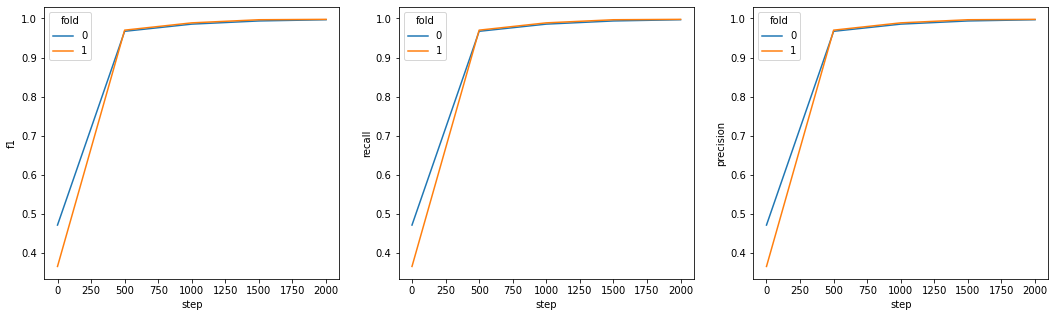

In [33]:
if args.do_eval:
    dfl = []
    for i in range(2):
        df = pd.DataFrame(loss_history[i])
        df['fold']=i
        dfl.append(df)
    eval_history = pd.concat(dfl).reset_index()
    eval_history['step'] = eval_history['step'].astype(int)
    eval_history['fold'] = eval_history['fold'].astype(int)

    fig, ax = plt.subplots(ncols=3, figsize=(18,5))
    seaborn.lineplot(data=eval_history, x='step', y='f1', hue='fold', ax=ax[0])
    seaborn.lineplot(data=eval_history, x='step', y='recall', hue='fold', ax=ax[1])
    seaborn.lineplot(data=eval_history, x='step', y='precision', hue='fold', ax=ax[2])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

## Append to other results 

In [ ]:
merged_result_file = '../results/merged_results.csv.gz'
results = pd.read_csv(merged_result_file)

In [ ]:
entities = results.entity_id.str.replace(r"\_[0-9]+\_[0-9]+", "").unique()
len(entities)

In [ ]:
sanity_check = predlist_df[['entity_id', 'label']].set_index('entity_id').join(results[['entity_id', 'label']].set_index('entity_id'),
                                                                how='inner',rsuffix='_or')

(sanity_check['label'] == sanity_check['label_or']).sum()==sanity_check.shape[0]

In [ ]:
predlist_df.set_index('entity_id', inplace=True)
results.set_index('entity_id', inplace=True)

In [ ]:
total_results = results.drop(robbert_col_name, axis=1, errors='ignore').join(predlist_df[[robbert_col_name]], how='left')

In [ ]:
total_results

In [ ]:
total_results[['category', 'label', robbert_col_name]].to_csv(f"../results/{mod_name}_predictions.csv.gz", index=True, compression='gzip')

In [ ]:
robberts = [c for c in total_results.columns if 'robbert' in c]
unanimous = total_results.dropna()[['label', 'bilstm_cv', 'rule_based']+robberts].apply(lambda x: x[0]==x[1]==x[2]==x[3]==x[4], 
                                                                         axis=1)

In [ ]:
sum(unanimous)/total_results.loc[total_results[robbert_col_name].isna()==False].shape[0]

In [ ]:
def number_of_dissenters(x):
    return int(x[0] != x[1])+\
           int(x[0] != x[2])+\
           int(x[0] != x[3])+\
           int(x[0] != x[4])+\
           int(x[0] != x[5])+\
           int(x[0] != x[6])

In [ ]:
dissenters = total_results.dropna()[['label','bilstm', 'bilstm_cv','rule_based']+robberts]\
                            .apply(number_of_dissenters, axis=1)

total_results.dissenters = np.nan
total_results.loc[dissenters.index, 'dissenters'] = dissenters.astype(int)

In [ ]:
total_results

In [ ]:
# 80*2*10/60 hours for 2 epochs and block size 512
# 16*2*10/60 hours for 2 epochs and block size 128
# 6*2*10/60 hours for 2 epochs and block size 32

## 

## Inference in practice

Suppose we have some sentence:
```De patient vertoont tekenen van ischemische hartziekte. Op de MRI waren sporen van infarctie te zien. Ik concludeer dat hier sprake is van significante stenose```

Now, how do we deploy our model?
First we need to establish **what** we wish to label, for this we can use MedCAT trained on Dutch clinical texts to recognize medical concepts. For our purpose we may wish the constrain the possible medical concepts
to symptoms and pathologies. Now, given our approximated medical concepts we apply our negation model to 
estimate whether the concept is negated or not.
